# Model evaluation

- This notebook compares the performance of the two models trained to solve this exercise
- Both models have been trained with the same dataset.
- One of them in a Linerar Regression model. It was trained by executing the script in ../it/test.02.sh, with the set of hyperparameters that appears in ../config/config.lr01.json, and was saved in ../models/modellr01
- The other one is a Multilayer Perceptron. It was trained by executing the script in ../it/test.03.sh, with the set of hyperparameters that appears in ../config/config.mlp01.json, and was saved in ../models/modelmlp

In [60]:
import sys
sys.path.insert(0, "../src/main/python/")
from models import ConfigManager
from models import BinaryTextClassifier

import pandas as pd
pd.set_option('display.max_colwidth', None)

## Loading the models

In [61]:
logistic_regression_model = BinaryTextClassifier(artifacts_folder='../models/modellr01')
multilayer_perceptron_model = BinaryTextClassifier(artifacts_folder='../models/modelmlp01')

## Loading the testing dataset

- Notice that this dataset is different from the dataset used to train and also different from the dataset used to validate.
- The splitting of the dataset was made by the execution of the script ../it/test.01.sh

In [63]:
dataset = pd.read_csv('../data/dataset/testing_set.csv', sep=',')

## Predicting with the model
- We use here the two different models to precict over the testing texts.
- Given that and the original labels of the dataset, we can compare predictions with labels to measure the performance of the two different models
- The model returns a probability for every text, a float score between 1 and 0. To convert that to a binary label, a threshold must be defined: scores >= the threshold will be considered positive (1), the rest negatives (0)
- We calculate optimal threshold for models by selecting the one that gets a best f1 score (a global measure for the model that combines both precision and recall)

In [64]:
texts = dataset['Tweet'].to_list()
labels = dataset['ISIS Flag'].to_list()

lr_scores = logistic_regression_model.predict(texts)
mlp_scores = multilayer_perceptron_model.predict(texts)

In [65]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def get_optimal_threshold(labels, prediction_scores):
    
    def f1_score(precision, recall):
        return (2 * precision * recall) / (precision + recall)
    
    precisions, recalls, thresholds = precision_recall_curve(
        labels, prediction_scores
    )
    
    f1_scores = []
    for index, precision in enumerate(precisions):
        f1_scores.append(
            f1_score(precision, recalls[index])
        )
    return thresholds[np.argmax(f1_scores)]

mlp_threshold = get_optimal_threshold(labels, mlp_scores)
lr_threshold = get_optimal_threshold(labels, lr_scores)

print('Optimal threshold MLP:', mlp_threshold)
print('Optimal threshold LR:', lr_threshold)

mlp_predictions = [1 if x >= mlp_threshold else 0 for x in mlp_scores]
lr_predictions = [1 if x >= lr_threshold else 0 for x in lr_scores]

Optimal threshold MLP: 0.5247044
Optimal threshold LR: 0.58491015


## Precision-Recall-F1

- As can be observed, both models get very similar performance scores
- Both models have precision over 95%, so we can be more or less confident that when the model tag a tweet as pro-ISIS it is actually a pro-ISIS one
- The value of recall is not so high but always over 90%. So the coverage of the model could be improved. There are several pro-ISIS tweets that the model is not able to catch
- The conclusions about the performance of the model depend on the requirements of the specific use case in which the model would be used. In a specific use case, the recall score, for example may be not high enough, because finding almos all pro-ISIS tweets is critical. But in general, we can say the the performance seems relatively good.
- There is not significant difference between the performance of MLP and LR models

In [66]:
from sklearn.metrics import precision_score, recall_score, f1_score

mlp_precision = precision_score(labels, mlp_predictions)
mlp_recall = recall_score(labels, mlp_predictions)
mlp_f1 = f1_score(labels, mlp_predictions)

lr_precision = precision_score(labels, lr_predictions)
lr_recall = recall_score(labels, lr_predictions)
lr_f1 = f1_score(labels, lr_predictions)

print('           ', 'MLP               ', 'LR')
print('precision: ', mlp_precision, lr_precision)
print('recall:    ', mlp_recall, lr_recall)
print('f1:        ', mlp_f1, lr_f1)


            MLP                LR
precision:  0.9568527918781726 0.9692609548724657
recall:     0.9167173252279636 0.9009118541033435
f1:         0.936355169202111 0.9338374291115311


## Precision-Recall Curve
- As expected the precision-recall curves of the models are very similar
- And they have the typical shape of skilled model: a good score in recall doesn't mean a bad score in precision and viceversa 

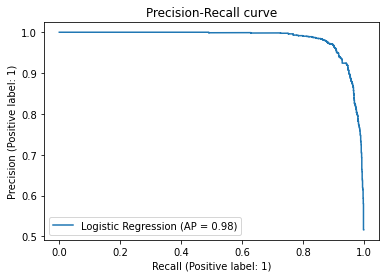

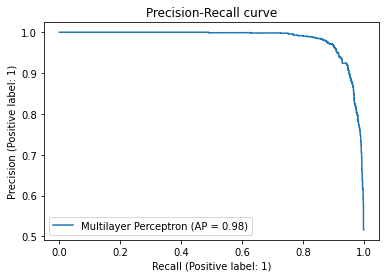

In [67]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(labels, logistic_regression_predictions, name="Logistic Regression")
_ = display.ax_.set_title("Precision-Recall curve")

display = PrecisionRecallDisplay.from_predictions(labels, logistic_regression_predictions, name="Multilayer Perceptron")
_ = display.ax_.set_title("Precision-Recall curve")

## Understanding errors
- For further work we need to see errors and try to understand why the models fail

In [68]:
dataset['MLP predictions'] = mlp_predictions
dataset['LR predictins'] = lr_predictions
dataset_errors = dataset[(dataset['MLP predictions'] == 0) & (dataset['ISIS Flag'] == 1)]
dataset_errors.head(200)

,ISIS Flag,Tweet,MLP predictions,LR predictins
47,1,@o0_o3 No. He appears to be the one who pretended to be Light Series. You can tell by how retarded he is. Its unmistakeable.,0,0
62,1,@dxcorcist standard magazine (30). looks fat when hold by a kid. @green_lemonnn,0,0
139,1,Picture of the day https://t.co/w0j8SPFvZn,0,0
198,1,"@BintSaaand no, it was a slip of the finger on the keyboard:)",0,0
201,1,@AfarinMamosta Pick a more good looking whore next time pig..,0,0
...,...,...,...,...
3077,1,@David_Cooks_ inv,0,0
3103,1,"When people mention ""Radical Muslim"" only Muwahhidin understand the true meaning of it. Being fundamental in Islam literally means accepting",0,0
3110,1,"Today's 'civilized' countries are based and operate effectively on Machiavellianism on saying ""The ends justify the means"". What is this?",0,0
3185,1,@LANURSE1 @realDonaldTrump They can't soldiers of Allah love death,0,1


In [69]:
dataset_errors = dataset[(dataset['MLP predictions'] == 1) & (dataset['ISIS Flag'] == 0)]
dataset_errors.head(200)

,ISIS Flag,Tweet,MLP predictions,LR predictins
7,0,This is IMPOSSIBLE \ud83d\ude2d https://t.co/lfomT8mSSg,1,0
19,0,Advanced Scanners is born! https://t.co/bFWSayCdUy,1,1
72,0,Among the findings in the Senate Intelligence Committee Preliminary report we released this week is that during the 2016 el\u2026,1,1
163,0,"Is it safe to remove #pest using pest spray?\nSpray maybe can get rid your pest, but the spray's chemical can spread\u2026 https://t.co/9YoWILNXfT",1,0
281,0,@1nekorektna @business Not sure why you felt the need to insult beasts... lol,1,1
...,...,...,...,...
3141,0,"Due to the Rend Lake Water problems that are affecting the city of Marion and all outlying areas, \nAll Unit # 2 Sch\u2026 https://t.co/CxS02Dezcp",1,1
3159,0,I have a dark side. Just so you know.,1,0
3161,0,"You are the Most Selfish Leader in Nigeria, Princ Agaga Tackle Obasanjo -",1,0
3216,0,madelaine and vanessa dressed as cheryl and toni in a youtube video re-enacting all the deleted choni scenes,1,0
